In [1]:
%matplotlib inline
import utils
import importlib
importlib.reload(utils)
from utils import *

In [2]:
import re, string, collections, bcolz, pickle, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix

The objective of this notebook is to train a sentiment analysis classifier given the games reviews in the dataset. The model must classify text reviews in positive or negative

In [3]:
df = pd.read_csv('data/reviews.csv', lineterminator='\n')

In [4]:
df.shape

(127699, 6)

There's 127699 games reviews

In [5]:
df.head()

,score,text,critic,date,title,platform
0,74.0,"it makes a terrible first impression, but ult...",Gaming Nexus,2014-11-18,#KILLALLZOMBIES,PlayStation 4
1,65.0,brings some fresh and inventive ideas to the ...,Playstation Universe,2014-11-17,#KILLALLZOMBIES,PlayStation 4
2,60.0,a fun main mode of play that can get quite add...,Gamers' Temple,2015-02-16,#KILLALLZOMBIES,PlayStation 4
3,60.0,"simply put, feels like half of a game.",DarkStation,2014-12-04,#KILLALLZOMBIES,PlayStation 4
4,60.0,"combined with the price and lack of cross-buy,...",Worth Playing,2014-11-30,#KILLALLZOMBIES,PlayStation 4


Let's keep just text and score columns

In [6]:
df = df[['text', 'score']]

In [7]:
df.head()

,text,score
0,"it makes a terrible first impression, but ult...",74.0
1,brings some fresh and inventive ideas to the ...,65.0
2,a fun main mode of play that can get quite add...,60.0
3,"simply put, feels like half of a game.",60.0
4,"combined with the price and lack of cross-buy,...",60.0


The data have 127699 reviews but we will keep just the most polarized ones. The filter is the next: <br>Positive: score > 85 <br/>Negative: score < 50

In [8]:
print(f'reviews with score greater than 85: {len(df.loc[df["score"] > 85])}')
print(f'reviews with score less than 50: {len(df.loc[df["score"] < 50])}')

reviews with score greater than 85: 43518
reviews with score less than 50: 20428


In [9]:
pos = df.loc[df['score'] > 85, 'text'].copy().reset_index(drop=True)
neg = df.loc[df['score'] < 50, 'text'].copy().reset_index(drop=True)

In [10]:
len(pos), len(neg)

(43518, 20428)

Let's print some positive reviews examples

In [21]:
for i in range(4):
    print(''.join(pos[np.random.randint(0, len(pos))]))
    print('\n')

 for what it is,  should be an award winning downloadable simple game that everyone can appreciate and enjoy.  to compare this game and knock it points because it doesn't compete against a bigger, completely different game like destiny is both unfair and foolish.  it is a masterfully simple and beautiful game that does what it intended to do perfectly with a few single flaw which will likely be patched soon (i show this flaw in my video).  i give this game a 9.5 out of 10 and rated it up based on the simplicity of its brilliance alone.  a rare gem in an overly complicated gaming world that sadly many people can't stop and appreciate and will take for granted.  it's much like someone ignoring a beautiful sunset right in front of them to text their 50th meaningless conversation of the day on their smart phone instead.


a really fun and addictive time online, single player, or with friends. if you enjoy rpg games this game is a must have. sure it is not perfect in graphics but most defin

Let's print some negative reviews examples

In [22]:
for i in range(4):
    print(''.join(neg[np.random.randint(0, len(neg))]))
    print('\n')

i dislike this game. it could have been so much better.


constantly having the batmobile shoehorned into mission, some of which are pure **** in terms of mechanics, ultimately ruined this game for me. compare to arkham city, this was a huge disappointment.


i do not recommend it. and the people who give it a score of 10, are activision workers and they themselves make the votes .... 0/10 this is called destiny 1.5 is a fraud


 is a mess - an altogether stress-inducing experience that i wouldn't wish upon anyone. i only hope the sequel proves to be a better experience.




We must add the labels: 0 for negative reviews, 1 for positive reviews

In [11]:
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns=['class'])], 1)
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(pos.shape), columns=['class'])], 1)

Mean, standard deviation and max length of negative reviews

In [12]:
lens = neg['text'].str.len()
lens.mean(), lens.std(), lens.max()

(681.7165654983356, 823.7599066187882, 14736)

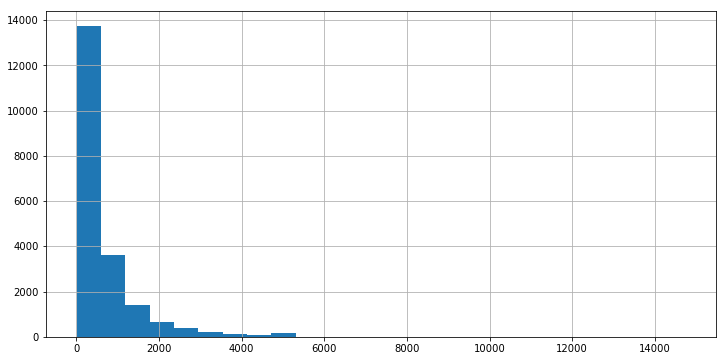

In [13]:
lens.hist(figsize=(12, 6), bins=25);

Reviews with more than 5000 characters are dropped

In [14]:
long_reviews = neg.loc[neg['text'].str.len() > 5000].index
neg.drop(long_reviews, inplace=True)

Mean, standard deviation and max length of positive reviews

In [15]:
lens = pos['text'].str.len()
lens.mean(), lens.std(), lens.max()

(586.1869801001884, 738.0401469961486, 25554)

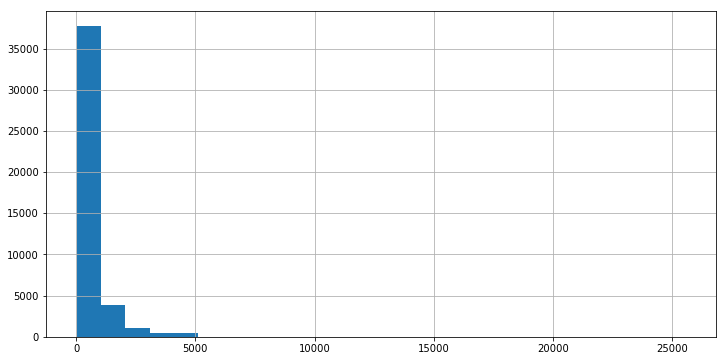

In [16]:
lens.hist(figsize=(12, 6), bins=25);

In [17]:
long_reviews = pos.loc[pos['text'].str.len() > 5000].index
pos.drop(long_reviews, inplace=True)

Is desirable to have a balanced dataset (similar quantity of positive and negative instances). So we will pick a random subset of the positive instances.

In [18]:
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)

In [19]:
neg.shape, pos.shape

((20419, 2), (20419, 2))

We concatenate positive and negative reviews

In [20]:
df = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
df.head()

,text,class
0,guys i got this game 2 days ago and i found it...,1.0
1,a resounding meh. less than even. this game ha...,0.0
2,"well, its out. i am a massive fan of the tony ...",0.0
3,a very good game that could have been a lot be...,1.0
4,"simply horrible. dlc full of glitches, lack of...",0.0


In [21]:
df.shape

(40838, 2)

Split data into train and test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['class'].values, test_size=0.2, random_state=42)

In [23]:
len(X_train), len(X_test), len(y_train), len(y_test)

(32670, 8168, 32670, 8168)

Defining tokenizer

In [24]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Creating bag of words

In [25]:
vect = CountVectorizer(tokenizer=tokenize)

In [26]:
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

Train term frequency contains 32675 documents and 45424 tokens. Each row represents a document and each column how many times that token appears on the document.

In [27]:
tf_train

<32670x45094 sparse matrix of type '<class 'numpy.int64'>'
	with 2560062 stored elements in Compressed Sparse Row format>

For instance, the first document have just 65 of the 45424 possible tokens. That's why the matrix is stored as a sparse matrix.

In [28]:
tf_train[0]

<1x45094 sparse matrix of type '<class 'numpy.int64'>'
	with 65 stored elements in Compressed Sparse Row format>

Get vocabulary

In [29]:
vocab = vect.get_feature_names()
len(vocab)

45094

In [30]:
vocab[4000: 4005]

['awful', 'awfull', 'awfully', 'awfulness', 'awful—the']

In [31]:
X_train[0]

"on paper, then,  is an exciting proposition that bundles the promises of aspirational game design with the raw power and fun associated with motorbikes. unfortunately, those promises are broken and the resulting game falls flat. unless you're so enamoured with two-wheeled machines that you simply can't help but pick yourself up a copy, you should wait for a new contender to try its hand at delivering a biking game of this scope."

First review's tokens

In [32]:
w0 = set([o for o in X_train[0].split(' ')])

In [33]:
w0

{'',
 'a',
 'an',
 'and',
 'are',
 'aspirational',
 'associated',
 'at',
 'biking',
 'broken',
 'bundles',
 'but',
 "can't",
 'contender',
 'copy,',
 'delivering',
 'design',
 'enamoured',
 'exciting',
 'falls',
 'flat.',
 'for',
 'fun',
 'game',
 'hand',
 'help',
 'is',
 'its',
 'machines',
 'motorbikes.',
 'new',
 'of',
 'on',
 'paper,',
 'pick',
 'power',
 'promises',
 'proposition',
 'raw',
 'resulting',
 'scope.',
 'should',
 'simply',
 'so',
 'that',
 'the',
 'then,',
 'this',
 'those',
 'to',
 'try',
 'two-wheeled',
 'unfortunately,',
 'unless',
 'up',
 'wait',
 'with',
 'you',
 "you're",
 'yourself'}

In [34]:
vect.vocabulary_['unless']

41989

In [35]:
tf_train[0, 41989]

1

### Multinomial Naive Bayes

Here we reduce our training data to 2 dimentions (using TruncatedSVD rather than PCA because we are working with sparse matrices) and then we plot it in order to  roughly see how classes are separated

In [36]:
svd = TruncatedSVD()
reduced_tf_train = svd.fit_transform(tf_train)

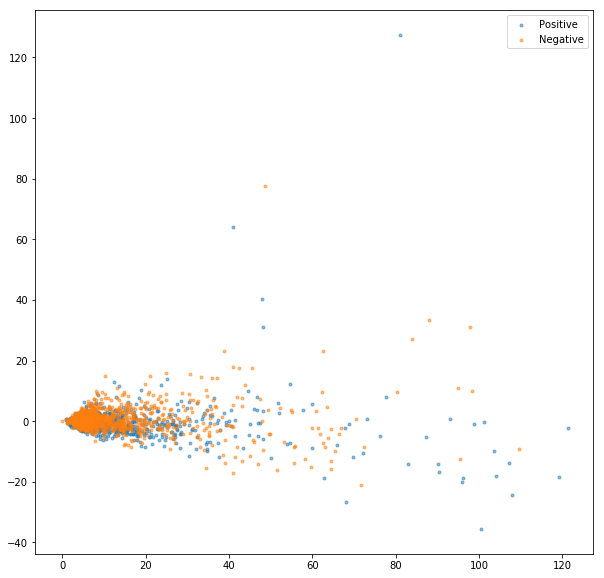

In [37]:
plot_embeddings(reduced_tf_train, y_train)

First attempt is to use a simple Multinomial Naive Bayes

In [38]:
p = tf_train[y_train==1].sum(0) + 1
q = tf_train[y_train==0].sum(0) + 1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [39]:
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.9038932419196866


Rather than use r coefficients that we get trough Naive Bayes, let's learn them from data using Logistic Regression

In [40]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.9275220372184133


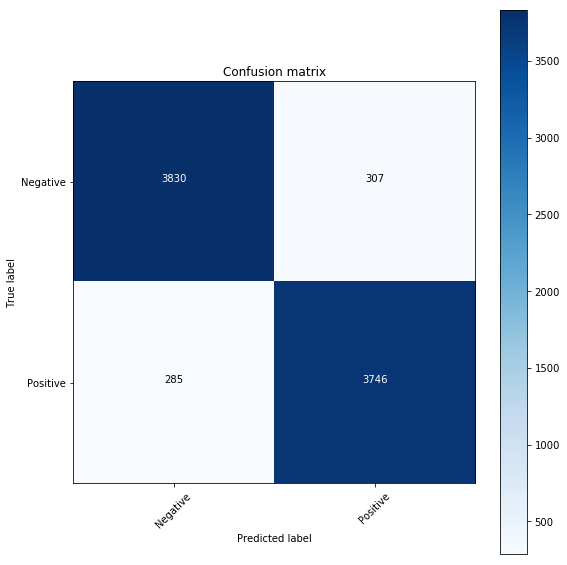

In [41]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

Let's plot most relevant words that the algorithm uses to classify a text in positive or negative

In [42]:
coef_df = pd.DataFrame({'vocab': vocab, 'coef':model.coef_.reshape(-1)})
pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

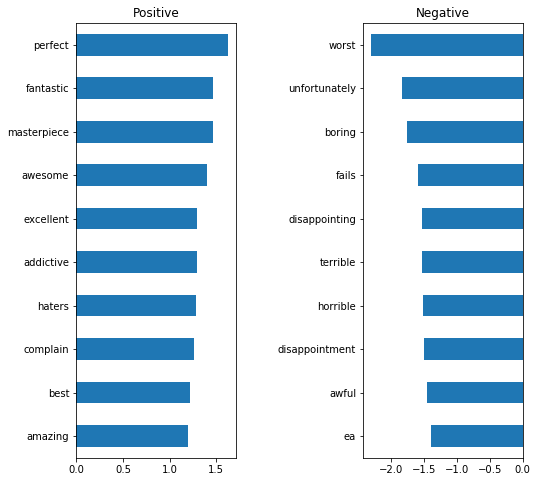

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');

Removing 'ea' token

In [44]:
vect.vocabulary_['ea']

12893

In [45]:
tf_train = lil2(tf_train)
tf_train.removecol(12893)

In [48]:
tf_test = lil2(tf_test)
tf_test.removecol(12893)

In [59]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.9280117531831538


Let's try now with bigram tf-idf rather than unigram tf

In [54]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)

In [55]:
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

Division between classes is more clear now

In [58]:
svd = TruncatedSVD()
reduced_tfidf_train = svd.fit_transform(tfidf_train)

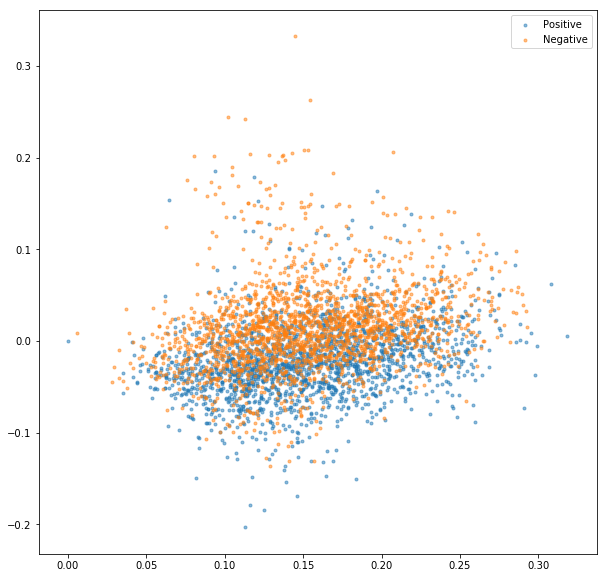

In [59]:
plot_embeddings(reduced_tfidf_train, y_train, 2000)

In [61]:
p = tfidf_train[y_train==1].sum(0) + 1
q = tfidf_train[y_train==0].sum(0) + 1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [65]:
model = LogisticRegression(C=30, dual=True)
model.fit(tfidf_train, y_train)
preds = model.predict(tfidf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.9483349657198825


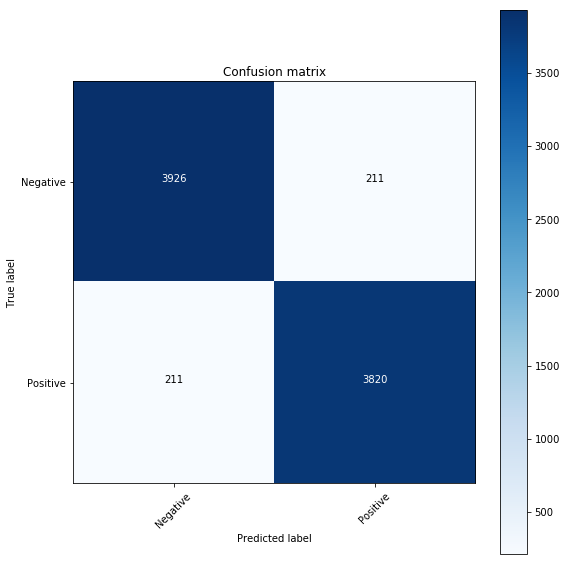

In [66]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

### CNN

We will try now with a simple Convolutional Neural Network

In [67]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input, concatenate
from keras.optimizers import Adam

/home/martinpella/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tokenize reviews

In [68]:
df['tokenized'] = df['text'].apply(tokenize)

Get vocabulary

In [69]:
def update_vocab_counter(row):
    for word in row:
        vocab_counter[word] += 1

In [70]:
vocab_counter = collections.Counter()
df['tokenized'].apply(update_vocab_counter);
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)

In [71]:
len(vocab)

49981

Word to index dictionary

In [73]:
w2id = {w:i for i, w in enumerate(vocab)}

Words to index transformation

In [74]:
def transform_to_ids(row):
    return [w2id[w] for w in row]

In [75]:
df['tokenized'] = df['tokenized'].apply(lambda x: transform_to_ids(x))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df['tokenized'].values, df['class'].values, test_size=0.2, random_state=42)

In [77]:
maxlen = 1000

All the inputs to the conv net must have a fixed size. We set 1000 as the max length and we fill with -1 all reviews smaller than 1000.

In [78]:
x_train = pad_sequences(X_train, maxlen=maxlen, value=-1)
x_test = pad_sequences(X_test, maxlen=maxlen, value=-1)

In [91]:
model = Sequential([Embedding(input_dim=len(vocab), output_dim=32, input_length=maxlen),
                    SpatialDropout1D(0.2),
                    Dropout(0.25),
                    Convolution1D(64, 5, padding='same', activation='relu'),
                    Dropout(0.25),
                    MaxPooling1D(),
                    Flatten(),
                    Dense(100, activation='relu'),
                    Dropout(0.85),
                    Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [92]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=4, batch_size=64)

Train on 32670 samples, validate on 8168 samples
Epoch 1/4
32670/32670 [==============================] - 8s - loss: 0.4518 - acc: 0.7556 - val_loss: 0.1932 - val_acc: 0.9247
Epoch 2/4
32670/32670 [==============================] - 8s - loss: 0.1879 - acc: 0.9352 - val_loss: 0.1781 - val_acc: 0.9344
Epoch 3/4
32670/32670 [==============================] - 8s - loss: 0.1323 - acc: 0.9557 - val_loss: 0.1965 - val_acc: 0.9345
Epoch 4/4
32670/32670 [==============================] - 8s - loss: 0.1015 - acc: 0.9672 - val_loss: 0.2129 - val_acc: 0.9327


Maybe finding best hyperparameters could lead to a better accuracy, but this more complex model is not better than our linear classifier.